In [1]:
%matplotlib inline
import cv2
import os,sys
import pickle
import mahotas
import scipy.stats
import sklearn.metrics

import matplotlib
import matplotlib.image as mpimg
import matplotlib.cm as cm # To color dots of scatter plots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from skimage.feature import hog
from scipy.stats import norm
from sklearn import preprocessing
from itertools import combinations
from PIL import Image

from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, './utilities/')

import utility_functions as utl
import feature_expansion_functions as ftexp
import helper_functions as hlp
import plot_functions as pltf

# Load the Data

In [3]:
# Loaded a set of images
root_dir = "../../Datasets/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [hlp.load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [hlp.load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

Loading 20 images
satImage_052.png
Loading 20 images
satImage_052.png


0.0


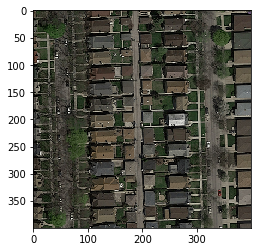

In [6]:
plt.imshow(imgs[0])
print(np.min(imgs[0]))

# Data Preprocessing

## Split the images into smaller patches

In [19]:
n = 4 # Only use 10 images for training
# Extract patches from input images
# size = 10(nb_images)*625(n_patches_per_image)*16*16(size_patch)*3(nb_channels)
patch_size = 16  # each patch is 16*16 pixels

img_patches = [hlp.img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [hlp.img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
#return array of size 6250 containing all the 625 patches for all the 10 training images
#gt has only 0 or 1 values
#img has an rgb value of size 3 for each point

# Extraction of Features from the images

In [20]:
#fd hist ne marche pas encore
def fd_histogram(image, mask=None):
    image = img_float_to_uint8(image)
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    # documentation: cv.calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]])
    hist  = cv2.calcHist([image], [0, 1, 2], None, [3, 3, 3], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    hist.flatten()
    
print(utl.fd_hu_moments(imgs[3]))
print(utl.fd_haralick(imgs[3]) ) 

[2.36089089e-03 1.31989277e-09 2.95904967e-12 7.73801105e-12
 4.66044940e-24 9.55746477e-17 3.67326717e-23]
[ 1.88039899e-04  9.03837665e+02  7.84923668e-01  2.10103189e+03
  1.20263066e-01  1.40146298e+02  7.50028990e+03  8.21881821e+00
  1.34113709e+01  1.30991713e-04  5.49662066e+00 -1.61067899e-01
  9.45007905e-01]


In [25]:
#Features definition
def features_definition_temp(img_patches):
    print("compute X1")
    X1 = np.asarray([ utl.extract_features(img_patches[i]) for i in range(len(img_patches))]) # dim 6
    print("Added dims: " + str(X1.shape[1]))
    X2 = np.asarray([ utl.laplace_gaussian_edge_detection(img_patches[i]) for i in range(len(img_patches))]) # dim 32
    print("Added dims: " + str(X2.shape[1]))
    X3 = np.asarray([ utl.horizontal_and_vertical_edge_detection(img_patches[i]) for i in range(len(img_patches))]) # dim 32
    print("Added dims: " + str(X3.shape[1]))
    X4 = np.asarray([ utl.get_grey_features(utl.get_gray_mask(img_patches[i])) for i in range(len(img_patches))]) # dim 32
    #X4 = np.asarray([ get_gray_mask(img_patches[i]).ravel() for i in range(len(img_patches))]) # dim 16 * 16
    print("Added dims: " + str(X4.shape[1]))
    X5 = np.asarray([ utl.threshold_eroded_img(img_patches[i]) for i in range(len(img_patches))]) # dim 32
    print("Added dims: " + str(X5.shape[1]))
    X6 = np.asarray([ utl.fd_hu_moments(img_patches[i]) for i in range(len(img_patches))]) # dim 7
    print("Added dims: " + str(X6.shape[1]))
    X7 = np.asarray([ utl.fd_haralick(img_patches[i]) for i in range(len(img_patches))]) # dim 13
    print("Added dims: " + str(X7.shape[1]))
    X8 = np.asarray([ utl.hog_features(img_patches[i]).ravel() for i in range(len(img_patches))]) # dim 16 * 16
    print("Added dims: " + str(X8.shape[1]))
    print("stop")
    X = np.concatenate((X1,X2,X3,X4,X6,X7,X8),axis=1) # dim 402
    #X = feature_expansion(X,4) # dim = dim * degree
    X = ftexp.feature_interaction(X) # dim = dim**2
    X = ftexp.add_offset(X) # dim = dim + 1
    print(X.shape)

    return X

[autoreload of feature_expansion_functions failed: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 434, in superreload
    module = reload(module)
  File "/opt/anaconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/opt/anaconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "./utilities/feature_expansion_functions

In [26]:
X = features_definition_temp(img_patches)

compute X1
Added dims: 6
Added dims: 32
Added dims: 32
Added dims: 32
Added dims: 32
Added dims: 7


KeyboardInterrupt: 

In [ ]:
with open(r"../saved_data/all_features.pickle", "wb") as output_file:
    pickle.dump(X, output_file)

In [ ]:
#normalization
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

### Definition of the output y

In [28]:
### Definition of two classes for the patches
foreground_threshold = 0.2 # percentage of pixels > 1 required to assign a foreground label to a patch
#the class foreground has a bit of road in it (25% min)
Y = np.asarray([hlp.value_to_class(np.mean(gt_patches[i]), foreground_threshold) for i in range(len(gt_patches))])

### Statistics on computed features 

In [ ]:
pltf.print_feature_stats(X_scaled,Y)

In [ ]:
#hist_of_features(X)
corr1 = np.corrcoef(X_scaled.T)
f,a = plt.subplots()
heatmap_corr = a.imshow(corr1)
f.colorbar(heatmap_corr, ax=a)
res = np.where(corr1 > 0.95) #arbitrary threshold for strong correlation
listOfCoordinates= list(zip(res[0], res[1]))
listOfCoordinates = [cord for cord in listOfCoordinates if cord[0] != cord[1]] #remove diagonal
listOfCoordinates = {tuple(sorted(t)): t for t in listOfCoordinates}#remove commutative elements
print(listOfCoordinates.keys())
plt.savefig("../plots/correlation_matrix")

## PCA and Plots

In [ ]:
pca = PCA(n_components=300)
pca.fit(X_scaled)  

In [ ]:
X_reduced = pca.transform(X_scaled)

In [ ]:
print(X_reduced.shape)

In [ ]:
with open(r"../saved_data/all_features_pca_components.pickle", "wb") as output_file:
    pickle.dump(pca.components_, output_file)

In [ ]:
colors = ['c' if yi else 'm' for yi in Y]
print(pca.explained_variance_ratio_[:10], pca.components_.shape)  
plt.scatter(pca.components_[0],Y, s=20, c=colors)
#first component explains 99% variance -> but still no clear separation between y1 and y0
plt.show()

In [ ]:
plt.scatter(np.log(pca.components_[1]),np.log(pca.components_[3]), s=10, c=colors)
print(np.mean(pca.components_[0]), np.var(pca.components_[0]))
print(np.where(pca.components_[1] > 0.1), pca.components_[0].shape)

# Training of the model

In [29]:
#define parameters
#pb si on a 80% de negatif... ?
Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
    
proportion_class0 = (len(Y0)) / (len(Y))
proportion_class1 = (len(Y1)) / (len(Y))
print(proportion_class0,proportion_class1)
weight = {0:proportion_class1, 1:proportion_class0}

0.7412 0.2588


## 1) Logistic regression

In [ ]:
# train a logistic regression classifier
from sklearn import linear_model
import time

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e4,solver='liblinear',penalty='l1',class_weight=weight,verbose=3)
# Run the estimation
start = time.time()
logreg.fit(pca.components_.T, Y)
stop = time.time()
print(stop - start)

In [ ]:
# Predict on the training set
Z = logreg.predict(pca.components_.T)

## 2) SVM

In [ ]:
#in general the SVM performs better than the LogReg model
from sklearn import svm

clf2 = svm.SVC(C=10, cache_size=200, class_weight=weight, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)
clf2.fit(X_reduced, Y)  

In [ ]:
# Predict on the training set
Z = clf.predict(X_reduced)

In [ ]:
with open(r"../saved_data/all_features_svm_prediction.pickle", "wb") as output_file:
    pickle.dump(Z, output_file)
with open(r"../saved_data/all_features_svm_model.pickle", "wb") as output_file:
    pickle.dump(clf, output_file)

## Model evaluation

In [ ]:
print(sum(Y),sum(Z))

In [ ]:
#F1 Score
print(f1_score(Y, Z, average='binary'), accuracy_score(Y, Z))

In [ ]:
# Loaded a set of images
root_dir_test = "../../Datasets/test_set_images/test_"

n=50
print("Loading " + str(n) + " images")
test_imgs = []
for i in range(n-1):
    image_dir_test = root_dir_test + str(i+1) + "/"
    file = os.listdir(image_dir_test)
    #print("Loading " + str(file))
    test_imgs.append(load_image(image_dir_test + file[0]))

# Display of results

In [ ]:
img_idx = 11
Xi = extract_img_features(image_dir + files[img_idx],patch_size)
#normalization
scaler = preprocessing.MinMaxScaler()
scaler.fit(Xi)
Xi_scaled = scaler.transform(Xi)

pca1 = PCA(n_components=300)
pca1.fit(Xi_scaled.T)  
Zi = clf.predict(pca1.components_.T)
plt.scatter(Xi[:, 1], Xi[:, 2], c=Zi, edgecolors='k', cmap=plt.cm.Paired)
plt.show()

In [ ]:
print(sum(Zi))

In [ ]:
w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)

## Submission

In [ ]:
#TODO: make feature mat from test_set data and make predictions and then the csv
#use the remaining imgs as validation set
n = 10 # Only use 10 images for test
patch_size = 16  # each patch is 16*16 pixels

img_patches_val = [img_crop(imgs[i], patch_size, patch_size) for i in np.arange(10,20,1)]
gt_patches_val = [img_crop(gt_imgs[i], patch_size, patch_size) for i in np.arange(10,20,1)]

# Linearize list of patches
img_patches_val = np.asarray([img_patches_val[i][j] for i in range(len(img_patches_val)) for j in range(len(img_patches_val[i]))])
gt_patches_val =  np.asarray([gt_patches_val[i][j] for i in range(len(gt_patches_val)) for j in range(len(gt_patches_val[i]))])

In [ ]:
X_val = features_definition_temp(img_patches_val)

In [ ]:
X_val_scaled = scaler.transform(X_val)

In [ ]:
test_components = pca.transform(X_val_scaled)  

In [ ]:
print(test_components.shape, X_val_scaled.shape)

In [ ]:
Z_val = clf.predict(test_components)

In [ ]:
Y_val = np.asarray([hlp.value_to_class(np.mean(gt_patches_val[i]), foreground_threshold) for i in range(len(gt_patches_val))])

In [ ]:
print(Y_val.shape,Z_val.shape)

In [ ]:
print(f1_score(Y_val, Z_val, average='binary'), accuracy_score(Y_val, Z_val))

In [ ]:
sum(Z_val)

# Experimental features

In [ ]:
#line detection
#TODO: transformer ca en feature
def proba_hough_tranform(img):
    img = img_float_to_uint8(img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #edges = cv2.Canny(gray,50,150,apertureSize = 3)
    edges = ndimage.gaussian_laplace(gray, sigma=2.5)
    features = np.zeros_like(2*img.shape[0])
    
    #plt.imshow(edges)
    #plt.show()
    minLineLength = 100
    maxLineGap = 120
    lines = cv2.HoughLinesP(edges,0.01,np.pi/360,100,minLineLength,maxLineGap)
    for i in range(len(lines)):
        #print(lines[i])
        for x1,y1,x2,y2 in lines[i]:
            cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
            
    #cv2.imwrite('houghlines5.jpg',img)
    plt.imshow(img)
    plt.show()
    
    return features
   
proba_hough_tranform(imgs[3])
plt.imshow(gt_imgs[3])

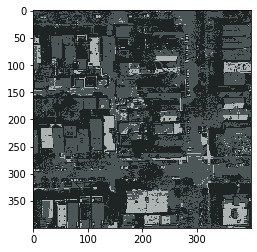

In [15]:
#kmeans algorithm for segmentation
def kmeans_segmentation(img, K=5):
    """
    params: K = number of representative colors to keep
    """
    img = hlp.img_float_to_uint8(img)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    vectorized = img.reshape((-1,3))
    vectorized = np.float32(vectorized)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    attempts=10
    ret,label,center = cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img.shape))


kmeans_segmentation(imgs[3])

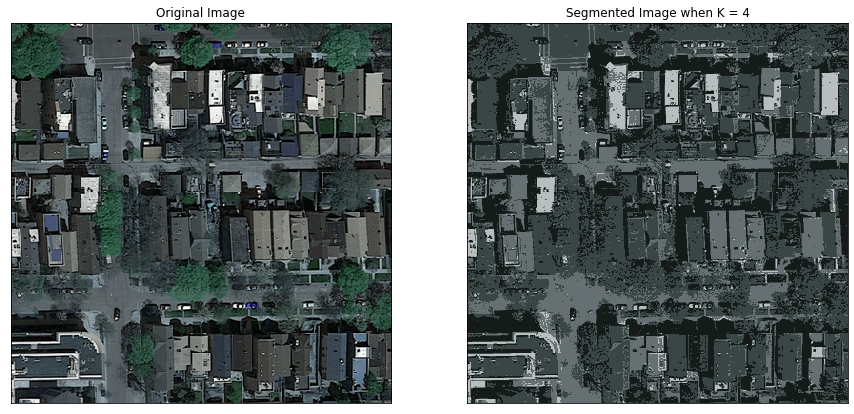

In [11]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()